# Predict Calorie Expenditure

In [1]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.sankey import Sankey

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
from scipy.stats import norm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
import hdbscan
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import itertools
from sklearn.linear_model import LassoCV
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import GradientBoostingRegressor


In [64]:
calorie_train = "train.csv"
calorie_test = "test.csv"

In [65]:
calorie_train_df = pd.read_csv(calorie_train)
calorie_train_df

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0
...,...,...,...,...,...,...,...,...,...
749995,749995,male,28,193.0,97.0,30.0,114.0,40.9,230.0
749996,749996,female,64,165.0,63.0,18.0,92.0,40.5,96.0
749997,749997,male,60,162.0,67.0,29.0,113.0,40.9,221.0
749998,749998,male,45,182.0,91.0,17.0,102.0,40.3,109.0


In [66]:
calorie_test_df = pd.read_csv(calorie_test)
calorie_test_df

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8
1,750001,male,26,200.0,97.0,20.0,101.0,40.5
2,750002,female,29,188.0,85.0,16.0,102.0,40.4
3,750003,female,39,172.0,73.0,20.0,107.0,40.6
4,750004,female,30,173.0,67.0,16.0,94.0,40.5
...,...,...,...,...,...,...,...,...
249995,999995,female,56,159.0,62.0,6.0,85.0,39.4
249996,999996,male,32,202.0,101.0,3.0,84.0,38.4
249997,999997,female,31,164.0,64.0,14.0,98.0,40.1
249998,999998,female,62,158.0,61.0,25.0,106.0,40.7


## Understand the Training Data

In [67]:
numeric_cols_train = calorie_train_df.select_dtypes(include= ['number']).columns
print("Numeric Columns in Train:\n", numeric_cols_train)

Numeric Columns in Train:
 Index(['id', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp',
       'Calories'],
      dtype='object')


In [68]:
numeric_cols_test = calorie_test_df.select_dtypes(include=['number']).columns
print("Numeric Columns in Test:\n", numeric_cols_test)

Numeric Columns in Test:
 Index(['id', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp'], dtype='object')


In [69]:
nonnumeric_cols_train = calorie_train_df.select_dtypes(include=['object']).columns
print("Non-Numeric Columns in Train:", nonnumeric_cols_train)

Non-Numeric Columns in Train: Index(['Sex'], dtype='object')


In [70]:
nonnumeric_cols_test = calorie_test_df.select_dtypes(include=['object']).columns
print("Non-Numeric Columns in Test:", nonnumeric_cols_test)

Non-Numeric Columns in Test: Index(['Sex'], dtype='object')


In [71]:
# one-hot encoding for Sex column
calorie_train_df['Gender'] = calorie_train_df['Sex'].map({'male': 1, 'female': 0})
calorie_test_df['Gender'] = calorie_test_df['Sex'].map({'male': 1, 'female': 0})
calorie_train_df = calorie_train_df.drop(['id', 'Sex'], axis = 1)
calorie_test_df = calorie_test_df.drop(['id', 'Sex'], axis = 1)

## Check the correlation between target and features

In [72]:
calorie_sex_corr = calorie_train_df[['Calories', 'Gender']].corr()
calorie_sex_corr

,Calories,Gender
Calories,1.000000,0.012011
Gender,0.012011,1.000000


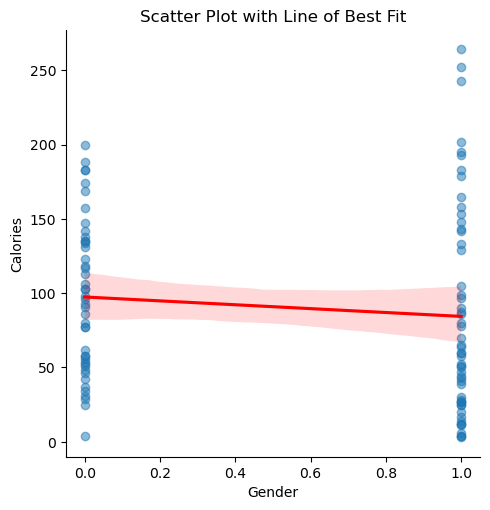

In [11]:
sample_df = calorie_train_df.sample(n=100, random_state=42)

sns.lmplot(x = 'Gender', y = 'Calories', data = sample_df,
           scatter_kws= {'alpha': 0.5},
           line_kws= {'color': 'red'})

plt.title("Scatter Plot with Line of Best Fit")
plt.xlabel("Gender")
plt.ylabel("Calories")
plt.show()

In [12]:
# Check the correlation between age and calories in Train
calorie_age_corr = calorie_train_df[['Calories', 'Age']].corr()
print(calorie_age_corr)

          Calories       Age
Calories  1.000000  0.145683
Age       0.145683  1.000000


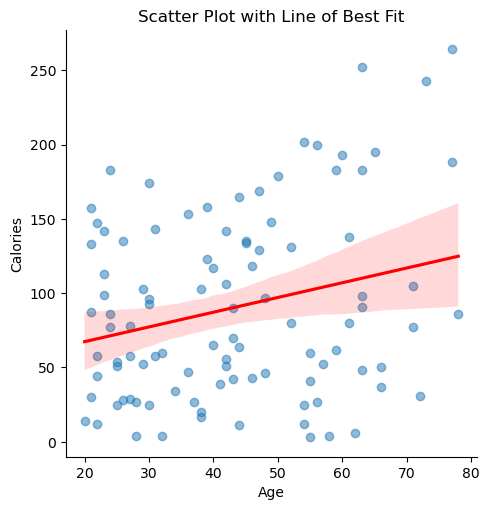

In [13]:
sns.lmplot(x = 'Age', y = 'Calories', data = sample_df,
           scatter_kws = {'alpha':0.5}, line_kws = {"color":"red"})

plt.title("Scatter Plot with Line of Best Fit")
plt.xlabel("Age")
plt.ylabel("Calories")
plt.show()

In [14]:
# Check the correlation between height and calories in Train
calorie_height_corr = calorie_train_df[['Calories', 'Height']].corr()
print(calorie_height_corr)

          Calories    Height
Calories  1.000000 -0.004026
Height   -0.004026  1.000000


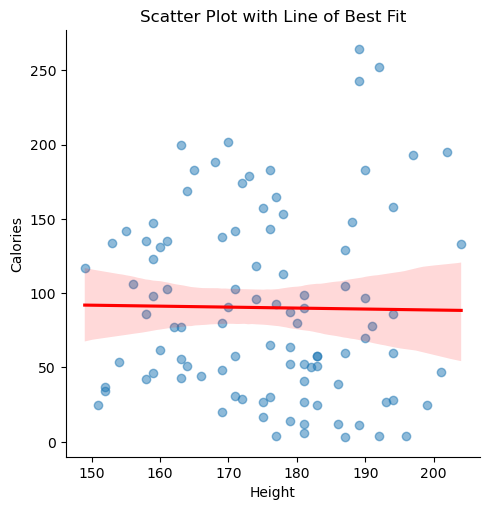

In [15]:
sns.lmplot(x = 'Height', y = 'Calories', data = sample_df,
           scatter_kws = {'alpha':0.5}, line_kws = {"color":"red"})

plt.title("Scatter Plot with Line of Best Fit")
plt.xlabel("Height")
plt.ylabel("Calories")
plt.show()

In [16]:
# Check the correlation between weight and calories in Train
calorie_weight_corr = calorie_train_df[['Calories', 'Weight']].corr()
print(calorie_weight_corr)

          Calories    Weight
Calories  1.000000  0.015863
Weight    0.015863  1.000000


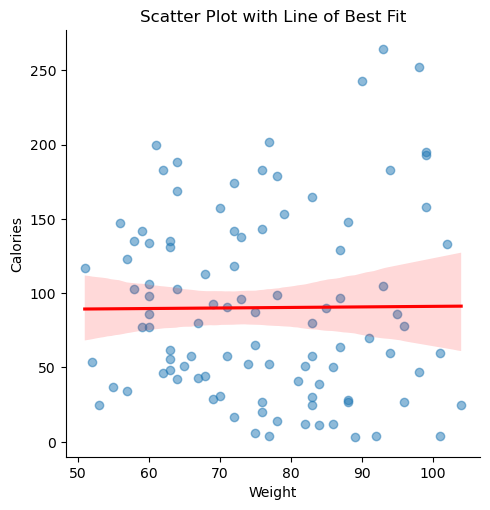

In [17]:
sns.lmplot(x = 'Weight', y = 'Calories', data = sample_df,
           scatter_kws = {'alpha':0.5}, line_kws = {"color":"red"})

plt.title("Scatter Plot with Line of Best Fit")
plt.xlabel("Weight")
plt.ylabel("Calories")
plt.show()

In [18]:
# Check the correlation between duration and calories in Train
calorie_duration_corr = calorie_train_df[['Calories', 'Duration']].corr()
print(calorie_duration_corr)

          Calories  Duration
Calories  1.000000  0.959908
Duration  0.959908  1.000000


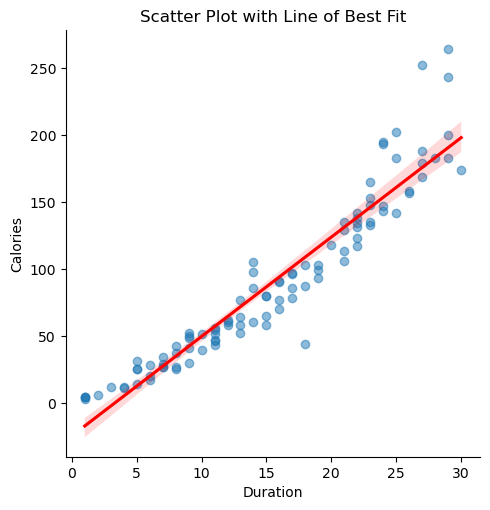

In [19]:
sns.lmplot(x = 'Duration', y = 'Calories', data = sample_df, 
           scatter_kws = {'alpha':0.5}, line_kws = {"color":"red"})

plt.title("Scatter Plot with Line of Best Fit")
plt.xlabel("Duration")
plt.ylabel("Calories")
plt.show()

In [20]:
# Check the correlation between heartrate and calories in Train
calorie_heartrate_corr = calorie_train_df[['Calories', 'Heart_Rate']].corr()
print(calorie_heartrate_corr)

            Calories  Heart_Rate
Calories    1.000000    0.908748
Heart_Rate  0.908748    1.000000


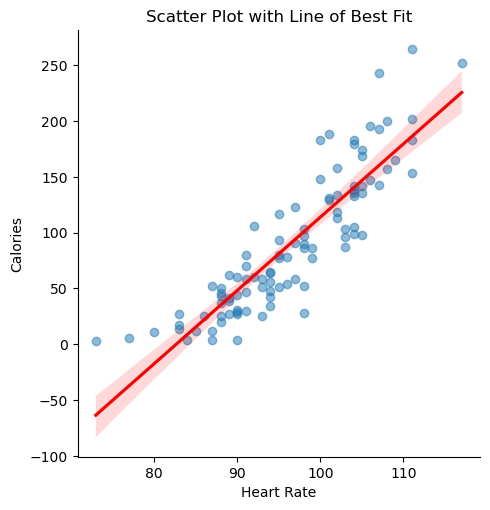

In [21]:
sns.lmplot(x = 'Heart_Rate', y = 'Calories', data = sample_df, 
           scatter_kws = {'alpha':0.5}, line_kws = {"color":"red"})

plt.title("Scatter Plot with Line of Best Fit")
plt.xlabel("Heart Rate")
plt.ylabel("Calories")
plt.show()

In [22]:
# Check the correlation between Body Temp and calories in Train
calorie_bodytemp_corr = calorie_train_df[['Calories', 'Body_Temp']].corr()
print(calorie_bodytemp_corr)

           Calories  Body_Temp
Calories   1.000000   0.828671
Body_Temp  0.828671   1.000000


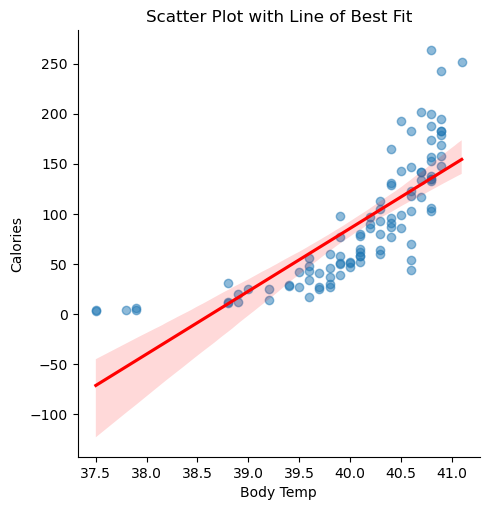

In [23]:
sns.lmplot(x = 'Body_Temp', y = 'Calories', data = sample_df, 
           scatter_kws = {'alpha': 0.5}, line_kws = {"color": "red"})

plt.title("Scatter Plot with Line of Best Fit")
plt.xlabel("Body Temp")
plt.ylabel("Calories")
plt.show()

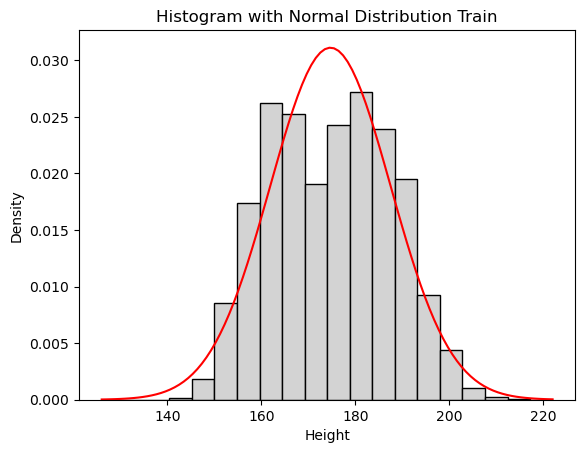

In [24]:
height_data = calorie_train_df['Height']
count, bins, ignored = plt.hist(height_data, bins = 20, density = True,
                                color = 'lightgray', edgecolor = 'black')
mu = np.mean(height_data)
sigma = np.std(height_data)
x = np.linspace(height_data.min(), height_data.max(), 100)

plt.plot(x, norm.pdf(x, mu, sigma), color = 'red')

plt.title('Histogram with Normal Distribution Train')
plt.xlabel('Height')
plt.ylabel('Density')
plt.show()

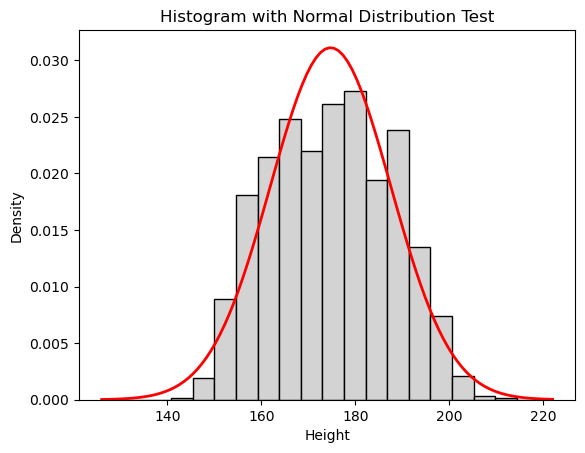

In [25]:
height_data_test = calorie_test_df['Height']

plt.hist(height_data_test, bins=20, density=True, color='lightgray', edgecolor='black')

mu, sigma = height_data_test.mean(), height_data_test.std()
x_1 = np.linspace(min(height_data_test), max(height_data_test), 100)
plt.plot(x, norm.pdf(x, mu, sigma), 'r', linewidth=2)

plt.title('Histogram with Normal Distribution Test')
plt.xlabel('Height')
plt.ylabel('Density')
plt.show()

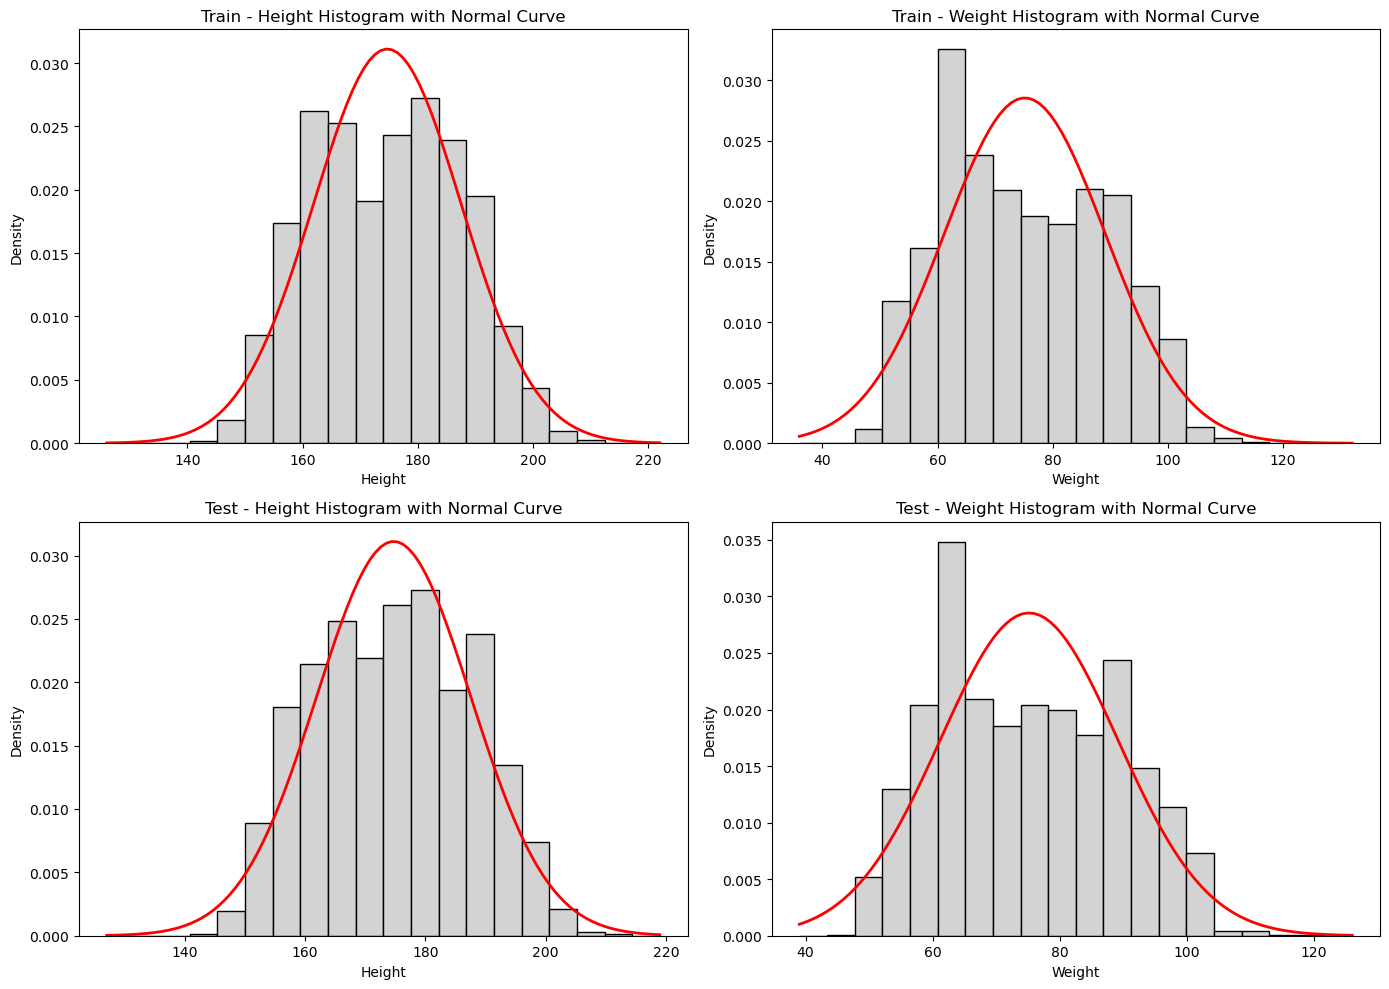

In [26]:
fig, ax = plt.subplots(2, 2, figsize = (14, 10))

# === Plot 1: Height Histogram (Train) ===
height_data = calorie_train_df['Height']
mu, sigma = height_data.mean(), height_data.std()
x = np.linspace(min(height_data), max(height_data), 100)
ax[0, 0].hist(height_data, bins=20, density=True, color='lightgray', edgecolor='black')
ax[0, 0].plot(x, norm.pdf(x, mu, sigma), 'r', linewidth=2)
ax[0, 0].set_title('Train - Height Histogram with Normal Curve')
ax[0, 0].set_xlabel('Height')
ax[0, 0].set_ylabel('Density')

# === Plot 2: Weight Histogram (Train) ===
weight_data = calorie_train_df['Weight']
mu, sigma = weight_data.mean(), weight_data.std()
x = np.linspace(min(weight_data), max(weight_data), 100)
ax[0, 1].hist(weight_data, bins=20, density=True, color='lightgray', edgecolor='black')
ax[0, 1].plot(x, norm.pdf(x, mu, sigma), 'r', linewidth=2)
ax[0, 1].set_title('Train - Weight Histogram with Normal Curve')
ax[0, 1].set_xlabel('Weight')
ax[0, 1].set_ylabel('Density')

# === Plot 3: Height Histogram (Test) ===
height_data_test = calorie_test_df['Height']
mu, sigma = height_data_test.mean(), height_data_test.std()
x = np.linspace(min(height_data_test), max(height_data_test), 100)
ax[1, 0].hist(height_data_test, bins=20, density=True, color='lightgray', edgecolor='black')
ax[1, 0].plot(x, norm.pdf(x, mu, sigma), 'r', linewidth=2)
ax[1, 0].set_title('Test - Height Histogram with Normal Curve')
ax[1, 0].set_xlabel('Height')
ax[1, 0].set_ylabel('Density')

# === Plot 4: Weight Histogram (Test) ===
weight_data_test = calorie_test_df['Weight']
mu, sigma = weight_data_test.mean(), weight_data_test.std()
x = np.linspace(min(weight_data_test), max(weight_data_test), 100)
ax[1, 1].hist(weight_data_test, bins=20, density=True, color='lightgray', edgecolor='black')
ax[1, 1].plot(x, norm.pdf(x, mu, sigma), 'r', linewidth=2)
ax[1, 1].set_title('Test - Weight Histogram with Normal Curve')
ax[1, 1].set_xlabel('Weight')
ax[1, 1].set_ylabel('Density')

# Tidy layout
plt.tight_layout()
plt.show()

### Conclusion
* Calories Burned is a continous target- therefore a regression model is the most suitable
* Linear Relationship with Calories: Age, Duration, Heart Rate, and Body_Temp
* Uncertain Relationship- Gender, Age
* +Strong Correlation: Body Temp, Heart Rate, and Duration
* +Weak Correlation- Weight, Age, and Gender
* -Weak Correlation- Height
* Since Duration of Exercise affects Heart Rate, which affects Body Heat which affects calories burnt- there is possible bias (Need to run a regression)
* From research, height and weight do affect calories burnt, but from the scatterplots, it isn't true. Moreover, histograms (with the normal distribution curve in red) for Weight in Train and Test show skewness for lowering weights. Maybe a feature is needed.


## Data Cleaning

In [73]:
calorie_train_df.shape

(750000, 8)

In [74]:
calorie_test_df.shape

(250000, 7)

In [75]:
print(calorie_train_df.isnull().sum())

Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
Gender        0
dtype: int64


In [76]:
print(calorie_test_df.isnull().sum())

Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Gender        0
dtype: int64


## Feature Engineering Beofre EDA

In [77]:
for df in [calorie_train_df, calorie_test_df]:
    df['temp_per_minute'] = df['Body_Temp'] / df['Duration']

In [78]:
def age_group(age):
    if age < 20:
        return 'Teen'
    elif age < 30:
        return 'Young Adult'
    elif age < 45:
        return 'Adult'
    elif age < 60:
        return 'Middle Aged'
    else:
        return 'Senior'
    
for df in [calorie_train_df, calorie_test_df]:
    df['age_group'] = df['Age'].apply(age_group)
    duration_by_age_group = df.groupby('age_group')['Duration'].mean().to_dict()
    df['Exercise_Duration_BY_Age'] = df['age_group'].map(duration_by_age_group)

for df in [calorie_train_df, calorie_test_df]:
    Age_Group_map = {'Teen': 1, 'Young Adult': 0, 'Adult': 2, 'Middle Aged': 3, 'Senior': 4}
    df['Age_Group'] = df['age_group'].map(Age_Group_map)
    df['Age_Group'] = df['age_group'].map(Age_Group_map)

In [79]:
calorie_train_df

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Gender,temp_per_minute,age_group,Exercise_Duration_BY_Age,Age_Group
0,36,189.0,82.0,26.0,101.0,41.0,150.0,1,1.576923,Adult,15.548594,2
1,64,163.0,60.0,8.0,85.0,39.7,34.0,0,4.962500,Senior,15.951226,4
2,51,161.0,64.0,7.0,84.0,39.8,29.0,0,5.685714,Middle Aged,15.055578,3
3,20,192.0,90.0,25.0,105.0,40.7,140.0,1,1.628000,Young Adult,15.311409,0
4,38,166.0,61.0,25.0,102.0,40.6,146.0,0,1.624000,Adult,15.548594,2
...,...,...,...,...,...,...,...,...,...,...,...,...
749995,28,193.0,97.0,30.0,114.0,40.9,230.0,1,1.363333,Young Adult,15.311409,0
749996,64,165.0,63.0,18.0,92.0,40.5,96.0,0,2.250000,Senior,15.951226,4
749997,60,162.0,67.0,29.0,113.0,40.9,221.0,1,1.410345,Senior,15.951226,4
749998,45,182.0,91.0,17.0,102.0,40.3,109.0,1,2.370588,Middle Aged,15.055578,3


## Exploratory Data Analysis

### 1. PCA

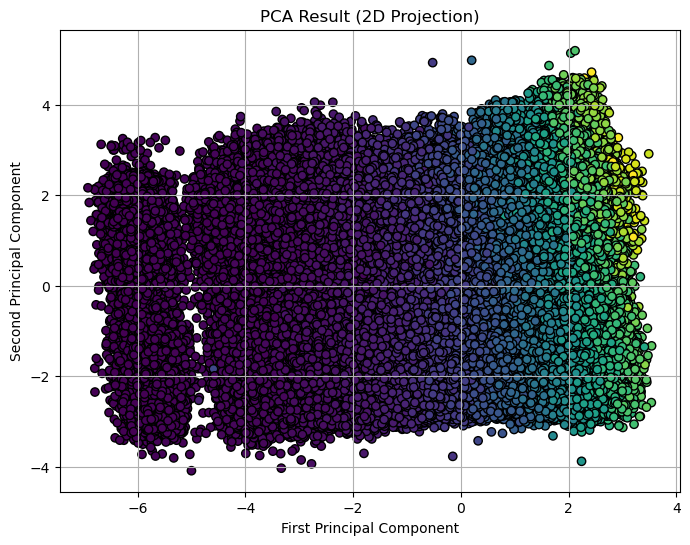

Explained variance ratio: [0.371997   0.29853137]


In [35]:
feature_columns = ['Body_Temp', 'Heart_Rate', 'Gender', 'Age', 'Duration', 
                   'temp_per_minute', 'Exercise_Duration_BY_Age','Height', 'Weight']
X = calorie_train_df[feature_columns]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = calorie_train_df['Calories']

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Result (2D Projection)')
plt.grid(True)
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)

In [36]:
loadings = pd.DataFrame(pca.components_.T, index = feature_columns, columns= ['PC1', 'PC2'])

print(loadings)

                               PC1       PC2
Body_Temp                 0.527771  0.047738
Heart_Rate                0.485678  0.058968
Gender                   -0.047503  0.547209
Age                       0.021019  0.038397
Duration                  0.515570  0.049974
temp_per_minute          -0.457159 -0.034212
Exercise_Duration_BY_Age  0.029092  0.013538
Height                   -0.062856  0.579768
Weight                   -0.057205  0.594432


### 2. t-SNE

In [37]:
feature_columns = ['Body_Temp', 'Heart_Rate', 'Gender', 'Age', 'Duration', 
                   'temp_per_minute', 'Exercise_Duration_BY_Age', 'Height', 'Weight']

sample_df = calorie_train_df.sample(n = 2000)
X_sample = sample_df[feature_columns]
y_sample = sample_df['Calories'] # For coloring (optional)

c:\Users\Jorden\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


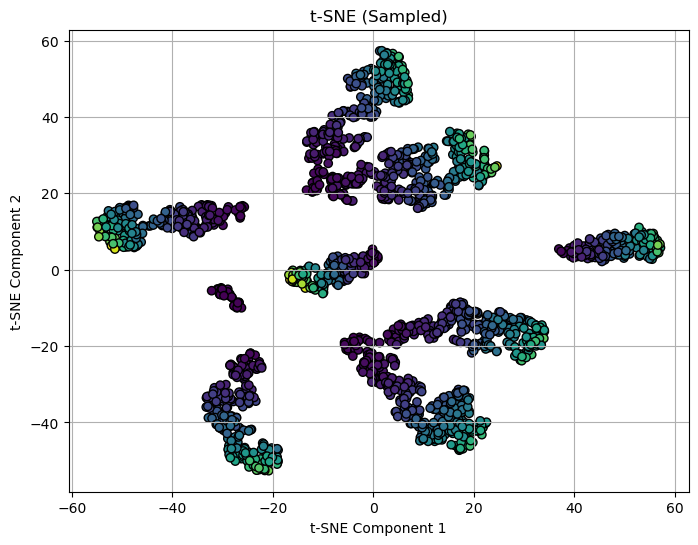

In [38]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)

tsne = TSNE(n_components= 2, perplexity= 30, random_state = 42, n_iter = 1000)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sample, cmap='viridis', edgecolor='k')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE (Sampled)')
plt.grid(True)
plt.show()

### 3. Clustering - DBSCAN


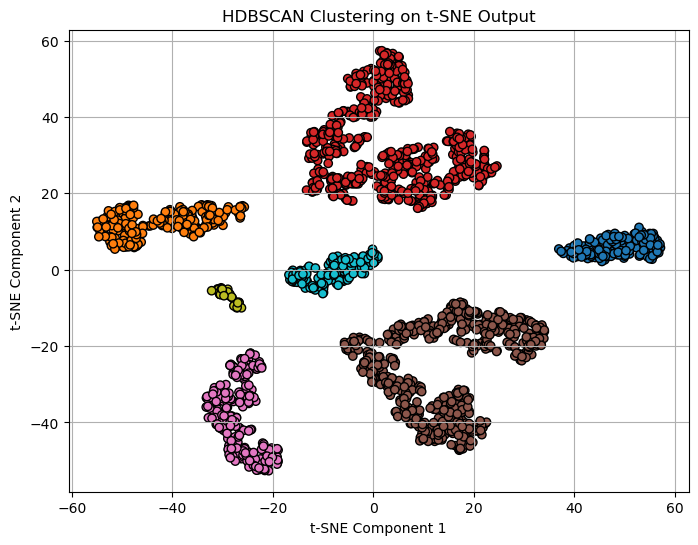

In [39]:
clusterer = hdbscan.HDBSCAN(min_cluster_size = 30, min_samples = 10)
cluster_labels = clusterer.fit_predict(X_tsne)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='tab10', edgecolor='k')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('HDBSCAN Clustering on t-SNE Output')
plt.grid(True)
plt.show()

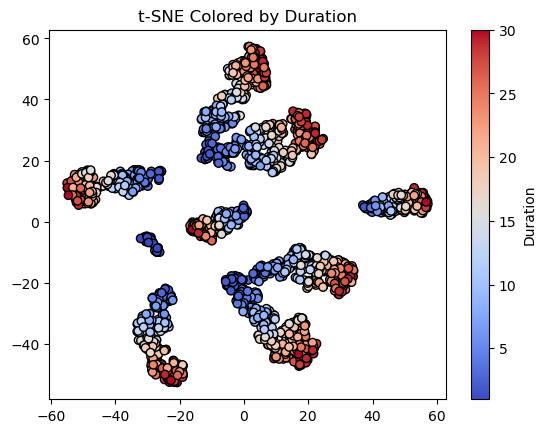

In [40]:
# Color by Duration
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=X_sample['Duration'], cmap='coolwarm', edgecolor='k')
plt.colorbar(label='Duration')
plt.title('t-SNE Colored by Duration')
plt.show()

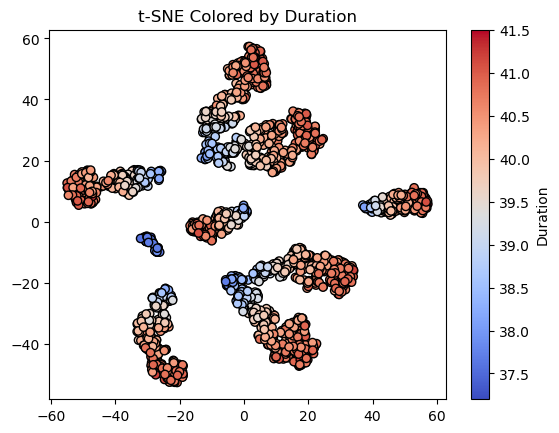

In [41]:
# Color by Body_Temp
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=X_sample['Body_Temp'], cmap='coolwarm', edgecolor='k')
plt.colorbar(label='Duration')
plt.title('t-SNE Colored by Duration')
plt.show()

In [42]:
# still going on...
# Use original features to predict HDBSCAN clusters
X_input = X_sample.copy()
y_clusters = cluster_labels

# Remove noise
mask = y_clusters != -1
X_input_clean = X_input[mask]


## Feature Engineering & Selection After EDA

New Features & Feature Selection

In [80]:
for df in [calorie_train_df, calorie_test_df]:
    df['Gender_Age'] = df['Gender'] * df['Age']
    df['Height_m'] = df['Height'] / 100
    df['BMI'] = df['Weight'] / (df['Height_m'] ** 2) ## Good for linear regression
    df['WtHt_Ratio'] = df['Weight'] / df['Height'] ## Works well with regression (Polynomial)
    df['Gender_Weight'] = df['Gender'] * df['Weight']
    df['BMI_Age'] = df['BMI'] * df['Age'] # Good for polynomial regression
    df['Intensity'] = df['Heart_Rate'] / df['Duration']
    df['Heart_Rate_Dur'] = df['Heart_Rate'] * df['Duration'] ## Also good for polynomial

Remove temp_per_minute & Exercise_Duration_BY_Age due to low correlation coefficients.

In [81]:
for df in [calorie_train_df, calorie_test_df]:
    columns_to_drop = ['temp_per_minute', 'Exercise_Duration_BY_Age']
    df.drop(columns=columns_to_drop, inplace=True)

In [82]:
# Use for Lasso Regression for Feature Selection
features_Lasso = ['Gender_Age', 'BMI', 'WtHt_Ratio',
                   'Gender_Weight', 'Age', 'BMI_Age', 'Gender', 'Body_Temp',
                   'Heart_Rate', 'Duration', 'Height', 'Weight', 'Intensity', 'Heart_Rate_Dur']
X_Lasso = calorie_train_df[features_Lasso]
y_Lasso = calorie_train_df['Calories']

lasso = make_pipeline(
    StandardScaler(),
    Lasso(alpha = 0.05, max_iter = 50000, random_state = 42)
)

lasso.fit(X_Lasso, y_Lasso)

model = lasso.named_steps['lasso']

non_zero_mask = model.coef_ != 0
selected_features = [f for f, keep in zip(features_Lasso, non_zero_mask) if keep]

print("Selected Features by Lasso:")
print(selected_features)

Selected Features by Lasso:
['Gender_Age', 'BMI', 'Gender_Weight', 'BMI_Age', 'Gender', 'Body_Temp', 'Heart_Rate', 'Duration', 'Height', 'Intensity', 'Heart_Rate_Dur']


In [46]:
# Remove non-numeric columns
for df in [calorie_train_df, calorie_test_df]:
    columns_to_drop = ['age_group']
    df.drop(columns = columns_to_drop, inplace = True)

## Models and Submission
1. Polynomial Regression + Ridge
2. XGB Regressor
3. KNN
4. CAT
5. LGBM
6. Gradient Booster
7. Mannual Ensemble Modle (Poly(Ridge) + XGB + CAT + LGBM).

In [47]:
feature_columns = ['Gender_Age', 'BMI', 'Gender_Weight', 'BMI_Age', 'Gender', 'Body_Temp', 
                   'Heart_Rate', 'Duration', 'Height', 'Intensity', 'Heart_Rate_Dur']

X = calorie_train_df[feature_columns]
y = calorie_train_df['Calories']

#### Polynomial Regression + Ridge

In [48]:
X_test_redge = calorie_test_df[feature_columns]

X_train_ridge, X_val_ridge, y_train_ridge, y_val_ridge = train_test_split(X, y, test_size=0.2, random_state=42)

model_ridge = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree = 3, include_bias = True),
    Ridge(alpha = 1)
)


model_ridge.fit(X_train_ridge, y_train_ridge)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('ridge', Ridge(alpha=1))])

In [49]:
y_pred = model_ridge.predict(X_val_ridge)
y_pred = np.maximum(0, y_pred)

rmsle = np.sqrt(mean_squared_log_error(y_val_ridge, y_pred))
print(f"Ridge Regression RMSLE (validation): {rmsle:.5f}")

Ridge Regression RMSLE (validation): 0.07243


#### XGB

In [50]:
X_test_XGB = calorie_test_df[feature_columns]

# 2. Train-validation split
X_train_XGB, X_val_XGB, y_train_XGB, y_val_XGB = train_test_split(X, y, test_size=0.2, random_state=42)


model_xgb = XGBRegressor(
    n_estimators = 100,
    learning_rate = 0.1,
    max_depth = 6,
    n_jobs = -1
)

model_xgb.fit(X_train_XGB, y_train_XGB)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=-1, num_parallel_tree=None, ...)

In [51]:
y_pred = model_xgb.predict(X_val_XGB)
y_pred = np.maximum(0, y_pred)

rmsle = np.sqrt(mean_squared_log_error(y_val_XGB, y_pred))
print(f"XGBRegressor RMSLE (validation): {rmsle:.5f}")

XGBRegressor RMSLE (validation): 0.06667


#### CAT

In [52]:
X_test_CAT = calorie_test_df[feature_columns]

X_train_CAT, X_val_CAT, y_train_CAT, y_val_CAT = train_test_split(X, y, test_size=0.2, random_state=42)

# assuming only 'Gender' is categorical
cat_features = [X.columns.get_loc('Gender')] # get the column index of 'Gender'

model_cat = CatBoostRegressor(
    iterations = 500,
    learning_rate= 0.05,
    depth = 6,
    verbose= 0
)

model_cat.fit(X_train_CAT, y_train_CAT, cat_features=cat_features, eval_set=(X_val_CAT, y_val_CAT))

In [53]:
y_pred = model_cat.predict(X_val_CAT)
y_pred = np.maximum(0, y_pred)

rmsle = np.sqrt(mean_squared_log_error(y_val_CAT, y_pred))
print(f"CAT Regressor RMSLE (validation): {rmsle:.5f}")

CAT Regressor RMSLE (validation): 0.06630


#### LGBM

In [54]:
X_test_LGBM =  calorie_test_df[feature_columns]

X_train_LGBM, X_val_LGBM, y_train_LGBM, y_val_LGBM = train_test_split(X, y, test_size=0.2, random_state=42)

model_lgbm = LGBMRegressor(
    n_estimators= 500,
    learning_rate= 0.05,
    max_depth= 6
)

model_lgbm.fit(X_train_LGBM, y_train_LGBM)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1375
[LightGBM] [Info] Number of data points in the train set: 597727, number of used features: 11
[LightGBM] [Info] Start training from score 88.383506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

LGBMRegressor(learning_rate=0.05, max_depth=6, n_estimators=500)

In [55]:
# Predict and evaluate
y_pred = model_lgbm.predict(X_val_LGBM)
y_pred = np.maximum(0, y_pred)  # RMSLE-safe

rmsle = np.sqrt(mean_squared_log_error(y_val_LGBM, y_pred))
print(f"LGBM Regressor RMSLE (validation): {rmsle:.5f}")

LGBM Regressor RMSLE (validation): 0.06369


#### Gradient Booster

In [56]:
X_test_GB = calorie_test_df[feature_columns]

X_train_GB, X_val_GB, y_train_GB, y_val_GB = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_GB = scaler.fit_transform(X_train_GB)
X_val_GB = scaler.transform(X_val_GB)

model_gbr = GradientBoostingRegressor(
    n_estimators= 200,
    learning_rate = 0.05,
    max_depth= 6,
    subsample= 0.8
)

model_gbr.fit(X_train_GB, y_train_GB)

GradientBoostingRegressor(learning_rate=0.05, max_depth=6, n_estimators=200,
                          subsample=0.8)

#### Ensemble Model

In [90]:
X_test_stacked = calorie_test_df[feature_columns]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models
poly_ridge = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree = 3, include_bias = False),
    Ridge(alpha = 0.05)
)

xgb = XGBRegressor(
    n_estimators = 100,
    learning_rate = 0.1,
    max_depth = 6,
    n_jobs = -1
)

cat = CatBoostRegressor(
    iterations = 1000,
    learning_rate = 0.05,
    depth = 6,
    verbose = 0
)

LGBM = LGBMRegressor(
    n_estimators = 500,
    learning_rate = 0.05,
    max_depth = 6
)

GBR = GradientBoostingRegressor(
    n_estimators = 200,
    learning_rate = 0.05,
    max_depth = 6,
    subsample = 0.8
)

stacked_model = StackingRegressor(
    estimators = [
        ('poly_ridge', poly_ridge),
        ('xbg', xgb),
        ('cat', cat),
        ('GBR', GBR),
    ],
    final_estimator = RidgeCV(),
    cv = 5,
    n_jobs = -1
)

y_train_log = np.log1p(y_train)

stacked_model.fit(X_train, y_train_log)

StackingRegressor(cv=5,
                  estimators=[('poly_ridge',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('polynomialfeatures',
                                                PolynomialFeatures(degree=3,
                                                                   include_bias=False)),
                                               ('ridge', Ridge(alpha=0.05))])),
                              ('xbg',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            earl...
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None, ...)),
                              ('cat',
                               <catboost.core.CatBoostRegressor object at 0x0000019EE6F9B320>),
                              ('GBR',
                               GradientBoostingRegressor(learning_rate=0.05,
                                                         max_depth=6,
                                                         n_estimators=200,
                                                         subsample=0.8))],
                  final_estimator=RidgeCV(), n_jobs=-1)

In [91]:
y_pred_log = stacked_model.predict(X_val)
y_pred = np.expm1(y_pred_log) 

rmsle = np.sqrt(mean_squared_log_error(y_val, y_pred))
print(f"Stacked Model RMSLE (validation): {rmsle:.5f}")

Stacked Model RMSLE (validation): 0.06039


In [92]:
test_predictions_stacked_log = stacked_model.predict(X_test_stacked)
test_predictions_stacked = np.expm1(test_predictions_stacked_log)

In [93]:
# Add DT predictions to test DataFrame
calorie_test_df['Calories_Predicted'] = test_predictions_stacked
calorie_test_help = pd.read_csv('test.csv')
calorie_test_df['id'] = calorie_test_help['id']
submission = calorie_test_df[['id', 'Calories_Predicted']]

submission.to_csv('submission_2.csv', index=False)
print("Submission file saved successfully!")

Submission file saved successfully!


In [89]:
test_predictions_stacked.shape

(250000,)